---
### Import Python Libraries
---

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import mlflow
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor  # Import XGBoost
from sklearn.linear_model import LinearRegression #LinearRegression


---
### Define Dataset Paths
---
1. Training to be done with data recorded in the month of **JULY**
2. Validation to be done with data recorded in the month of **AUGUST**
3. Testing to be done with data recorded in the month of **SEPTEMBER**

---

In [2]:
#define the training filepath
filename_jul_train = './dataset/yellow_tripdata_2023-08.parquet'
filename_aug_validate = './dataset/yellow_tripdata_2023-08.parquet'
filename_sept_test = './dataset/yellow_tripdata_2023-09.parquet'
model_output_filepath = './models'

---
### MLflow Configuration for Experiment Tracking
---
MLflow, is an open-source platform for managing the end-to-end machine learning lifecycle. 
It involves setting the tracking URI and experiment name.

**THE TRACKING URI**

1. The tracking URI is the location where MLflow logs and stores information about experiments, runs, and artifacts.
2. In this case, it is set to a local server running at http://127.0.0.1:5000. 
3. This means that MLflow will store its data in a SQLite database at that location.

**THE EXPERIMENT NAME**

1. In MLflow, an experiment is a named collection of runs, and it helps organize and track different machine learning workflows. 
2. The `mlflow.set_experiment` function is used to set the current experiment to the one specified by experiment_name. 
3. This means that any subsequent runs or logging within this script will be associated with the "POC_NYC-Yellow-Taxi-Experiment" experiment

---

In [10]:
# Set the tracking URI to use SQLite as the backend store
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set the experiment name mlflow
EXPERIMENT_NAME = "NYC-Yellow-Taxi-Experiment-POC-dataset-1000"
mlflow.set_experiment(EXPERIMENT_NAME)

2023/12/06 19:31:47 INFO mlflow.tracking.fluent: Experiment with name 'NYC-Yellow-Taxi-Experiment-POC-dataset-1000' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/6', creation_time=1701909107264, experiment_id='6', last_update_time=1701909107264, lifecycle_stage='active', name='NYC-Yellow-Taxi-Experiment-POC-dataset-1000', tags={}>

---
### Function:Data Preprocessing
---
This function reads a DataFrame from either a CSV file or a Parquet file, performs specific data preprocessing steps related to datetime, duration, filtering, and column manipulation, and returns the resulting DataFrame

Following functions are performed under data pre-processing:
1. File Format Check
2. Datetime Conversion:
3. Calculate Duration in Minutes
4. Filter Duration
5. Categorical Conversion
6. Create Combined Location ID
7. Return Processed DataFrame
---

In [5]:
def data_preprocess(filename):
    # Check file format and read DataFrame accordingly
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        
        # Convert datetime columns to pandas datetime objects
        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
        
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
        
    # Calculate trip duration in minutes
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # Filter trips based on duration (between 1 and 60 minutes)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    # Convert selected columns to string type for categorical representation
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    # Create a new column 'PU_DO' by combining pickup and dropoff location IDs
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    
    # Return the processed DataFrame
    return df


---
### Function: Distribution Plotting Function for Comparing Predicted and Actual Values
---

In [6]:
def plot_graph(y_train, y_pred, model_class):
    # Plot the distribution of predicted values using Seaborn
    print('====================================================================')
    print(f'\nplotting predicted and actual values for the model :{model_class}')
    sns.distplot(y_pred, label='prediction_linear_regression')

    # Plot the distribution of actual values using Seaborn
    sns.distplot(y_train, label='actual')

    # Display the legend to differentiate between the two distributions
    plt.legend()

# Example usage:
# plot_graph(y_train, y_pred)


---
### Function: MLflow Integration for Logging, Training, and Evaluating Machine Learning Models
---

In [7]:
def train_and_log_model(model_class, X_train, y_train, X_val, y_val):
    # Start an MLflow run
    with mlflow.start_run():
        # Log parameters, including file paths and the model name
        mlflow.log_params({
            "train-data-path": f"{filename_jul_train}",
            "valid-data-path": f"{filename_aug_validate}",
            "model-name": f"{model_class}"
        })

        # Log a preprocessor artifact
       # mlflow.log_artifact(f"{model_output_filepath}/preprocessor.b", artifact_path="preprocessor")
        # Train the model
        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        # Make predictions and calculate RMSE
        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        # Plot a distribution graph of actual vs predicted values
        plot_graph(y_train, y_pred, model_class)

        # Log the RMSE metric
        mlflow.log_metric("rmse", rmse)

        # Log the trained model
        mlflow.sklearn.log_model(mlmodel, "model")


In [8]:
def main(X_train, y_train, X_val, y_val):
    mlflow.sklearn.autolog()

    # List of regression models to iterate over
    regression_models = [
        RandomForestRegressor, 
        GradientBoostingRegressor, 
        ExtraTreesRegressor, 
        LinearSVR,
        XGBRegressor, 
        LinearRegression  # Include LinearRegression
    ]

    for model_class in regression_models:
        train_and_log_model(model_class, X_train, y_train, X_val, y_val)

---
---
### Main Function
---
---
#### Data Preprocessing and Dataset Initialization
---
1. The `data_preprocess` function on three different filenames corresponding to training, validation, and test datasets. 

2. It then prints the lengths of the resulting DataFrames for the training and validation datasets.

---
#### Feature Transformation using DictVectorizer
---
1. The lists `categorical` and `numerical` define the features to be treated as categorical and numerical, respectively.

2. The `DictVectorizer` is initialized.

3. The training data is converted to a dictionary of records (`train_dicts`) and then transformed into a sparse matrix (`X_train`) using the `fit_transform` method of `DictVectorizer`.

---


2023/12/06 19:32:35 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'



plotting predicted and actual values for the model :<class 'sklearn.ensemble._forest.RandomForestRegressor'>


/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction_linear_regression')
/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp


plotting predicted and actual values for the model :<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction_linear_regression')
/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp


plotting predicted and actual values for the model :<class 'sklearn.ensemble._forest.ExtraTreesRegressor'>


/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction_linear_regression')
/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp


plotting predicted and actual values for the model :<class 'sklearn.svm._classes.LinearSVR'>


/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction_linear_regression')
/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp


plotting predicted and actual values for the model :<class 'xgboost.sklearn.XGBRegressor'>


/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction_linear_regression')
/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp


plotting predicted and actual values for the model :<class 'sklearn.linear_model._base.LinearRegression'>


/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction_linear_regression')
/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_5657/3161087341.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp

Successfully completed


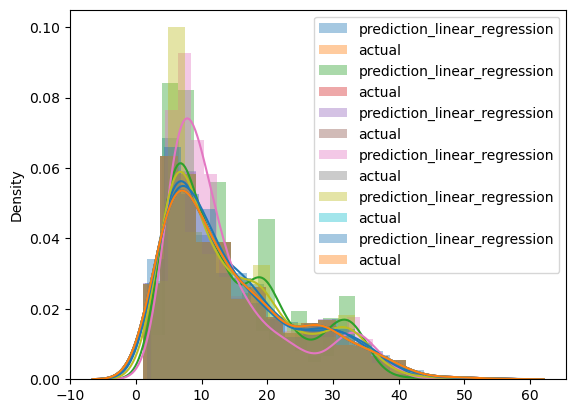

In [11]:
if __name__ == "__main__":
    # Preprocess the training data
    df_train = data_preprocess(filename_jul_train).head(1000)

    # Preprocess the validation data
    df_validate = data_preprocess(filename_aug_validate).head(1000)

    # Preprocess the test data
    df_test = data_preprocess(filename_sept_test).head(1000)

    # Print the lengths of the training and validation DataFrames
    len(df_train), len(df_validate)

    # Load your data (X_train, y_train, X_val, y_val)
    # Define categorical and numerical features : independant features
    categorical = ['PU_DO']
    numerical = ['trip_distance']

    # Initialize a DictVectorizer
    dv = DictVectorizer()

    # Convert training data to a dictionary of records and then transform it into a sparse matrix
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)

    # Convert validation data to a dictionary of records and then transform it into a sparse matrix
    val_dicts = df_validate[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dicts)

    # Convert test data to a dictionary of records and then transform it into a sparse matrix
    test_dicts = df_test[categorical + numerical].to_dict(orient='records')
    X_test = dv.transform(test_dicts)

    #dependant feature/target variable

    target = 'duration'

    y_train = df_train[target].values
    y_val = df_validate[target].values
    y_test = df_test[target].values

    # Call the main function with your data
    main(X_train, y_train, X_val, y_val)

    print("Successfully completed")

In [ ]:
# with open(f'{model_output_filepath}/lr-v-1.bin', 'wb') as f_out:
#     pickle.dump((dv, lr), f_out)
#     print("sucessfully recorded current model")

In [ ]:
# with mlflow.start_run():

#     mlflow.set_tag("developers","mlops-nyc-yellow-taxi")
#     mlflow.log_param("train-data_path",f"{filename_aug_train}")
#     mlflow.log_param("validate-data_path",f"{filename_sept_validate}")

#     alpha = 0.01

#     mlflow.log_param("alpha",f"{alpha}")
#     y_pred_lr, rmse =model_linear_regression(X_train,y_train)

#     mlflow.log_metric("rmse", rmse)
    


In [ ]:
# with mlflow.start_run():

#     mlflow.set_tag("developers","shreya","nyc-yellow-taxi","mlops")
#     mlflow.log_param("train-data_path",f"{filename_aug_train}")
#     mlflow.log_param("validate-data_path",f"{filename_sept_validate}")

#     alpha = 0.01

#     mlflow.log_param("alpha",f"{alpha}")
    


In [ ]:
# train = xgb.DMatrix(X_train, label=y_train)
# valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:

# def xgboost(params):
#     with mlflow.start_run():
#         mlflow.set_tag("model", "xgboost")
#         mlflow.log_params(params)
#         booster = xgb.train(
#             params=params,
#             dtrain=train,
#             num_boost_round=1,
#             evals=[(valid, 'validation')],
#             early_stopping_rounds=5
#         )
#         y_pred = booster.predict(valid)
#         rmse = mean_squared_error(y_val, y_pred, squared=False)
#         mlflow.log_metric("rmse", rmse)

#     return {'loss': rmse, 'status': STATUS_OK}

# search_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'reg:linear',
#     'seed': 42
# }

# best_result = fmin(
#     fn=xgboost,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=2,
#     trials=Trials()
# )

In [ ]:
# search_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'reg:linear',
#     'seed': 42
# }

# best_result = fmin(
#     fn=xgboost,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=2,
#     trials=Trials()
# )

In [ ]:
# params = {
    
# }

# mlflow.xgboost.autolog()

# with mlflow.start_run():
#     mlflow.set_tag()
#     mlflow.log_param()

#     booster = xgb.train(
#         booster = xgb.train(
#         params=params,
#         dtrain=train,
#         num_boost_round=1000,
#         evals=[(valid, 'validation')],
#         early_stopping_rounds=50
# )
#     )

In [ ]:
# #Fitting the linear regression model to the training data 
# def model_linear_regression(X_train,y_train):
#     lr = LinearRegression()
#     lr.fit(X_train, y_train)

#     #using the trained model to predict outcome of the validation data
#     y_pred = lr.predict(X_val)

#     print("The mean square error is --> ", mean_squared_error(y_val, y_pred, squared=False))
#     return y_pred, mean_squared_error(y_val, y_pred, squared=False)